https://www.alignmentforum.org/posts/z6QQJbtpkEAX3Aojj/interim-research-report-taking-features-out-of-superposition

In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib import cm

from scipy.stats import mode
from sklearn.manifold import TSNE
from sklearn.cluster import MiniBatchKMeans
from scipy.stats import pearsonr as corr

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

global_seed = 20230831

from main_cifar10 import *

Using device: cuda
Using device: cuda
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/cool_klindt/anaconda3/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/cool_klindt/anaconda3/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/cool_klindt/PerceptualSimilarity/lpips/weights/v0.1/alex.pth


In [2]:
log_dir = 'results/test4/'
with open(os.path.join(log_dir, 'results.pkl'), 'rb') as f:
    results = pickle.load(f)

results['layer1'].keys()

dict_keys(['output_shape', 'activations', 'activations_normed', 'kmeans_num_dic', 'kmeans_128', 'kmeans_128dist', 'kmeans_256', 'kmeans_256dist', 'kmeans_512', 'kmeans_512dist', 'data_train', 'data_test', 'data_train_kmeans_128', 'data_test_kmeans_128', 'data_train_kmeans_256', 'data_test_kmeans_256', 'data_train_kmeans_512', 'data_test_kmeans_512', 'probabilities', 'probabilities_kmeans_128', 'probabilities_kmeans_256', 'probabilities_kmeans_512', 'monosemanticity', 'monosemanticity_kmeans_128', 'monosemanticity_kmeans_256', 'monosemanticity_kmeans_512', 'kmeans_128_top', 'kmeans_128_topdist', 'data_train_kmeans_128_top', 'data_test_kmeans_128_top', 'monosemanticity_kmeans_128_top', 'kmeans_128_bottom', 'kmeans_128_bottomdist', 'data_train_kmeans_128_bottom', 'data_test_kmeans_128_bottom', 'monosemanticity_kmeans_128_bottom', 'kmeans_256_top', 'kmeans_256_topdist', 'data_train_kmeans_256_top', 'data_test_kmeans_256_top', 'monosemanticity_kmeans_256_top', 'kmeans_256_bottom', 'kmeans_2

In [3]:
X = results['layer1']['activations'].copy()
X.shape

(50000, 256)

In [198]:
class SparseAutoencoder(nn.Module):
    def __init__(self, num_in, num_hidden) -> None:
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(num_in, num_hidden, bias=True), 
            nn.ReLU(),
            #nn.ELU()
            #nn.GELU()
            #nn.BatchNorm1d(num_hidden),
        )
        self.decoder = nn.Linear(num_hidden, num_in)
        # init
        nn.init.orthogonal_(self.encoder[0].weight.data)
        self.decoder.weight.data /= torch.linalg.norm(self.decoder.weight, dim=0)

    def forward(self, x):
        z = self.encode(x)
        rec = self.decode(z)
        return z, rec
    
    def encode(self, x):
        z = self.encoder(x)
        #z = z * torch.sign(z)
        #z = torch.exp(z)
        return z
    
    def decode(self, z):
        #z = z + torch.zeros_like(z).exponential_(1e3)
        return self.decoder(z)


In [201]:
model = SparseAutoencoder(num_in=256, num_hidden=256).to(device)
optim = torch.optim.Adam(model.parameters(), 1e-3)
batch_size = 256

run_loss = {'loss_l2': [], 'loss_l1': [], 'loss_negent': []}
for i in range(10000):
    ind = np.random.choice(X.shape[0], batch_size)
    x = torch.tensor(X[ind]).to(device)
    z, rec = model(x)
    loss_l2 = torch.mean((x - rec) ** 2)
    loss_l1 = torch.mean(torch.abs(z))
    loss_negent = -torch.mean(torch.std(z, dim=0))
    loss = loss_l2 + 1e-1 * loss_l1 + 1e-2 * loss_negent
    optim.zero_grad()
    loss.backward()
    optim.step()
    model.decoder.weight.data /= torch.linalg.norm(model.decoder.weight, dim=0)
    run_loss['loss_l2'].append(loss_l2.item())
    run_loss['loss_l1'].append(loss_l1.item())
    run_loss['loss_negent'].append(loss_negent.item())
    if i > 0 and not i % 1000:
        print(i, [(key, np.mean(run_loss[key])) for key in run_loss])
        run_loss = {'loss_l2': [], 'loss_l1': [], 'loss_negent': []}
        

1000 [('loss_l2', 0.0002447298400431544), ('loss_l1', 0.0012594533333606967), ('loss_negent', -0.004845417099311709)]
2000 [('loss_l2', 0.0001624311763298465), ('loss_l1', 0.0012829705765470861), ('loss_negent', -0.007088100410066545)]
3000 [('loss_l2', 0.000149178573206882), ('loss_l1', 0.0013401422330643982), ('loss_negent', -0.00807662798417732)]
4000 [('loss_l2', 0.00014153203916794155), ('loss_l1', 0.0013758633431280032), ('loss_negent', -0.008782350923866034)]
5000 [('loss_l2', 0.00013583514613856095), ('loss_l1', 0.0013959488873369992), ('loss_negent', -0.009305598655715584)]
6000 [('loss_l2', 0.00013285684259608388), ('loss_l1', 0.0014007787550799548), ('loss_negent', -0.009636479784734546)]
7000 [('loss_l2', 0.0001318987268896308), ('loss_l1', 0.0014057715879753233), ('loss_negent', -0.009876870992593467)]
8000 [('loss_l2', 0.00013108992140041664), ('loss_l1', 0.001404904097202234), ('loss_negent', -0.010011598147451877)]
9000 [('loss_l2', 0.00013069978756539058), ('loss_l1', 

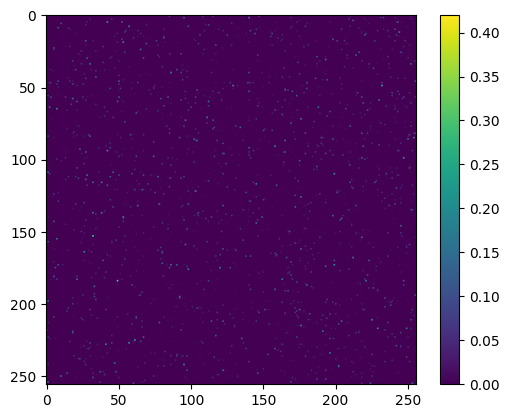

In [202]:
plt.imshow(z.detach().cpu().numpy())
plt.colorbar()

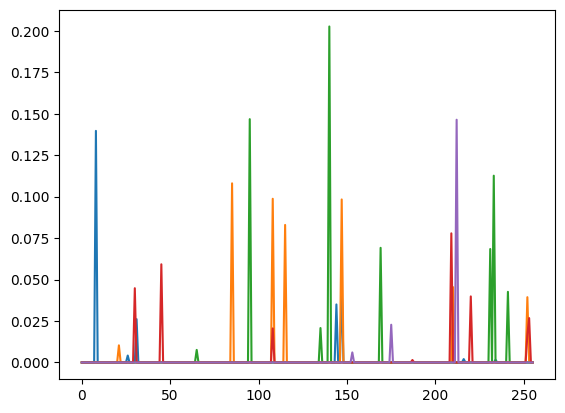

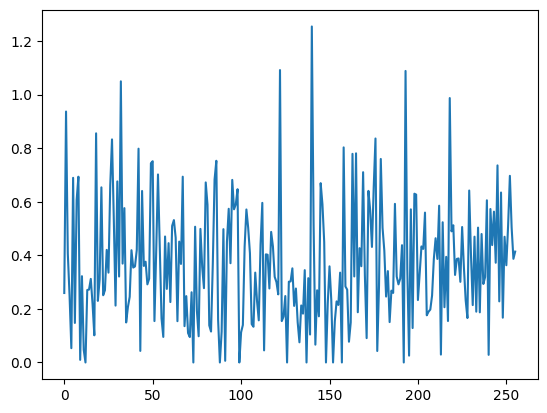

In [203]:
plt.plot(z[:5].detach().cpu().numpy().T)
plt.show()

plt.plot(z.sum(0).detach().cpu().numpy())
plt.show()

In [204]:
Z = model.encode(torch.tensor(X).to(device)).detach().cpu().numpy()
Z.shape

(50000, 256)

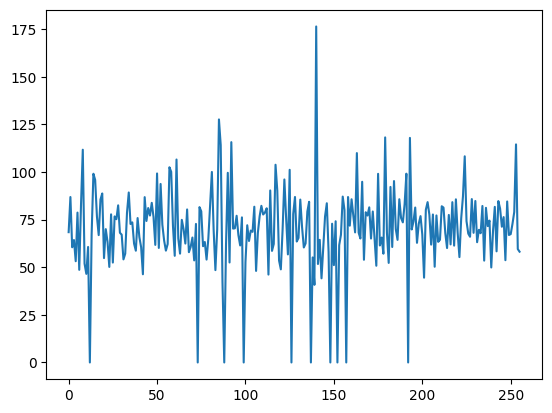

In [205]:
plt.plot(Z.sum(0))
plt.show()

In [206]:
ind_alive = Z.sum(0) > 0
print('alive', np.sum(ind_alive), '/', Z.shape[1])
Z = Z[:, ind_alive]
Z.shape

alive 246 / 256


(50000, 246)

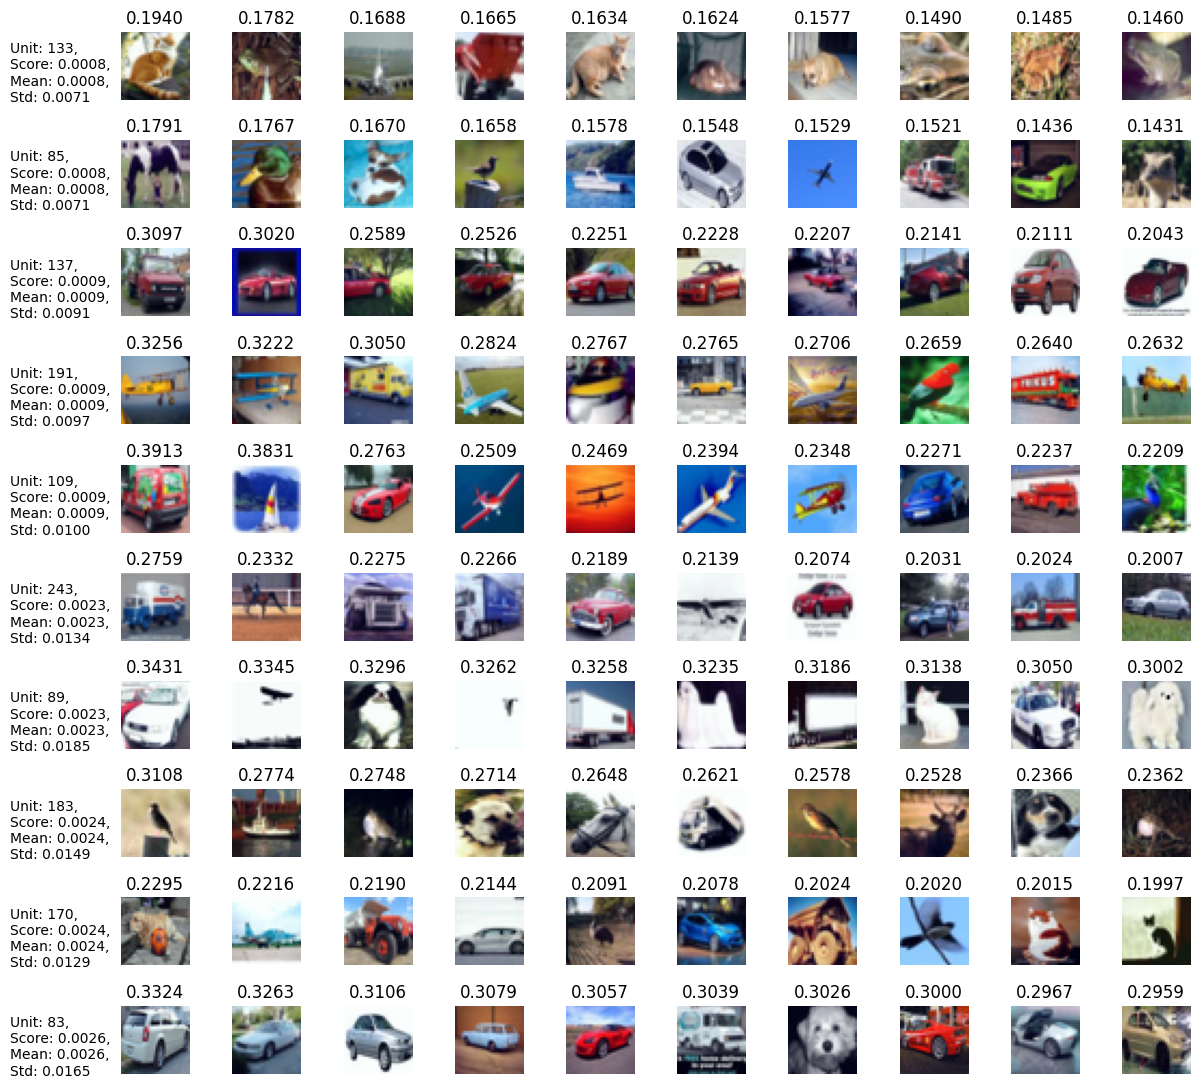

In [207]:
plot_meis(Z, Z.mean(0), 
          results['inputs'], '', 
          num_show=10, show_all=False, plot=True)

In [208]:
data_train, _ = get_mei_data(Z, results['inputs'])
scores = -get_monosemanticity(data_train)

[-0.15783558161638211, -0.14015665491024265, -0.14542295606579722]


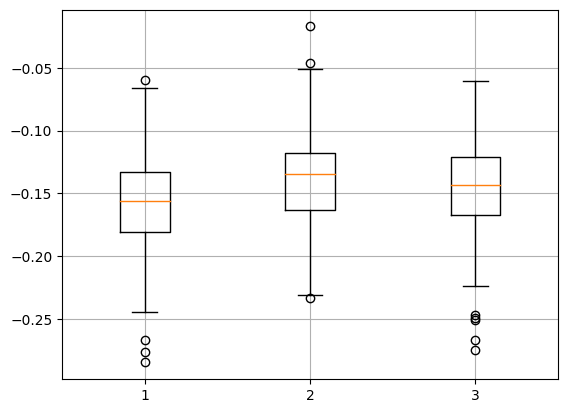

In [209]:
tmp = [
    -results['layer1']['monosemanticity'],
    -results['layer1']['monosemanticity_kmeans_256'],
    scores
]
print([np.mean(t) for t in tmp])
plt.boxplot(tmp)
plt.grid()

In [210]:
sparsity = np.geomspace(1e-3, 1e0, 10)
sparsity

array([0.001     , 0.00215443, 0.00464159, 0.01      , 0.02154435,
       0.04641589, 0.1       , 0.21544347, 0.46415888, 1.        ])

1000 [('loss_l2', 0.00024599827671985047), ('loss_l1', 0.001208358950174221), ('loss_negent', -0.004666286327603545)]
2000 [('loss_l2', 0.0001644527210155502), ('loss_l1', 0.0012688453174196184), ('loss_negent', -0.006943257226608693)]
3000 [('loss_l2', 0.00014967145338596312), ('loss_l1', 0.0013374907007673755), ('loss_negent', -0.008045348420739173)]
4000 [('loss_l2', 0.00014116906089475377), ('loss_l1', 0.0013688161517493426), ('loss_negent', -0.008753637922927738)]
5000 [('loss_l2', 0.00013578861177666112), ('loss_l1', 0.001387068559997715), ('loss_negent', -0.009278779775835574)]
6000 [('loss_l2', 0.00013290102961764205), ('loss_l1', 0.0013960859687067568), ('loss_negent', -0.009641206621192396)]
7000 [('loss_l2', 0.00013189409169717692), ('loss_l1', 0.001399887802428566), ('loss_negent', -0.009852856142446399)]
8000 [('loss_l2', 0.00013146663876250386), ('loss_l1', 0.0014024940248345955), ('loss_negent', -0.009994682421907783)]
9000 [('loss_l2', 0.00013115942638251), ('loss_l1', 

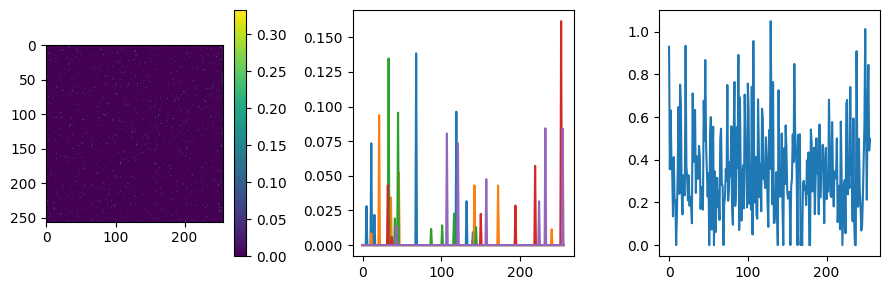

alive 242 / 256
sparsity 0.001 mean score -0.14596906215845307 


1000 [('loss_l2', 0.0002452513927945748), ('loss_l1', 0.0012800031323353393), ('loss_negent', -0.00481929450382392)]
2000 [('loss_l2', 0.0001646993522590492), ('loss_l1', 0.0012705242041265593), ('loss_negent', -0.006984141439199448)]
3000 [('loss_l2', 0.000150508062375593), ('loss_l1', 0.0013357257905881853), ('loss_negent', -0.008025572437793017)]
4000 [('loss_l2', 0.0001410807757783914), ('loss_l1', 0.0013802810466149822), ('loss_negent', -0.00883462906256318)]
5000 [('loss_l2', 0.0001344547660264652), ('loss_l1', 0.0014007049585925415), ('loss_negent', -0.009392521562986075)]
6000 [('loss_l2', 0.00013149437303945887), ('loss_l1', 0.0014104067420121283), ('loss_negent', -0.009752892977558077)]
7000 [('loss_l2', 0.00013041327844257467), ('loss_l1', 0.0014113713754341007), ('loss_negent', -0.009963467317633331)]
8000 [('loss_l2', 0.0001301112465807819), ('loss_l1', 0.0014123879269463942), ('loss_negent', -0.010110082471

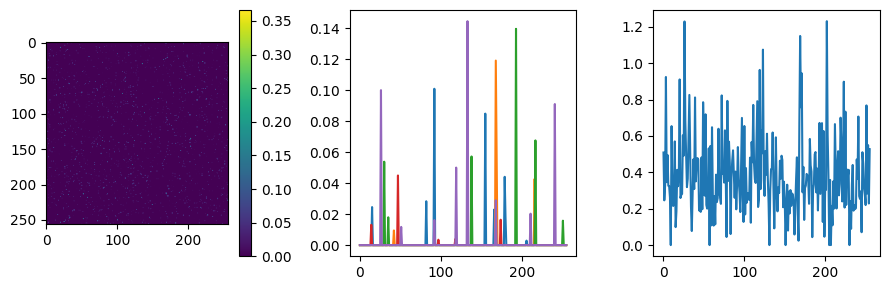

alive 249 / 256
sparsity 0.0021544346900318843 mean score -0.14476387572276544 


1000 [('loss_l2', 0.0002463614890204424), ('loss_l1', 0.0012419229603840502), ('loss_negent', -0.0047903805373368654)]
2000 [('loss_l2', 0.0001653707857913105), ('loss_l1', 0.0012659617054741829), ('loss_negent', -0.0069370006751269106)]
3000 [('loss_l2', 0.00015078607879695483), ('loss_l1', 0.0013293063887394965), ('loss_negent', -0.007965424612630159)]
4000 [('loss_l2', 0.00014164399613218848), ('loss_l1', 0.001366877055959776), ('loss_negent', -0.008748470498248935)]
5000 [('loss_l2', 0.00013604602923442143), ('loss_l1', 0.0013856152414809912), ('loss_negent', -0.009305839441716672)]
6000 [('loss_l2', 0.00013352370746724774), ('loss_l1', 0.0013926203229930251), ('loss_negent', -0.009660903298296034)]
7000 [('loss_l2', 0.00013252792658749967), ('loss_l1', 0.0013959238516399637), ('loss_negent', -0.009876758369617164)]
8000 [('loss_l2', 0.0001319280168536352), ('loss_l1', 0.0013970371253089978), ('loss_n

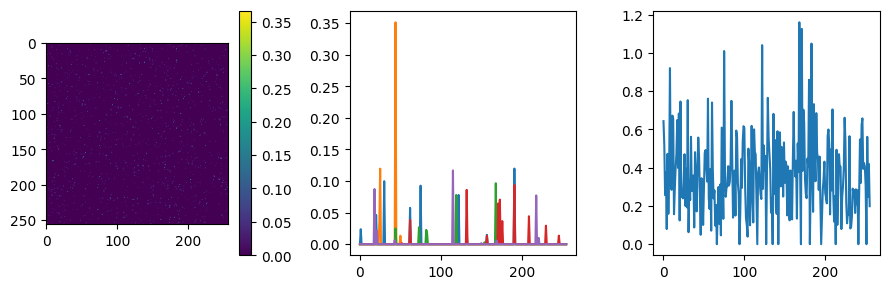

alive 244 / 256
sparsity 0.004641588833612777 mean score -0.14323935471856813 


1000 [('loss_l2', 0.0002529322282153207), ('loss_l1', 0.0011864344964011364), ('loss_negent', -0.004304378451737617)]
2000 [('loss_l2', 0.00016706813737982885), ('loss_l1', 0.0012608410972170532), ('loss_negent', -0.0067672386234626175)]
3000 [('loss_l2', 0.0001493885483505437), ('loss_l1', 0.001339475735789165), ('loss_negent', -0.007989973769988865)]
4000 [('loss_l2', 0.00014044384786393493), ('loss_l1', 0.0013746363208629192), ('loss_negent', -0.008762380292639137)]
5000 [('loss_l2', 0.00013516051095211878), ('loss_l1', 0.001393115147599019), ('loss_negent', -0.009306448748335243)]
6000 [('loss_l2', 0.00013248198301880622), ('loss_l1', 0.0014004955386044458), ('loss_negent', -0.009662662100978195)]
7000 [('loss_l2', 0.00013164577475981786), ('loss_l1', 0.0014029504586942495), ('loss_negent', -0.009883301585912704)]
8000 [('loss_l2', 0.0001312476988096023), ('loss_l1', 0.0014042021670611575), ('loss_nege

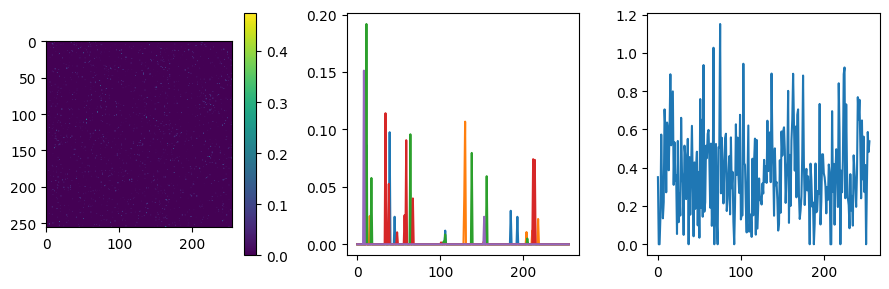

alive 244 / 256
sparsity 0.01 mean score -0.14519928198032936 


1000 [('loss_l2', 0.00023975769517192903), ('loss_l1', 0.001246473536285647), ('loss_negent', -0.004950736794708209)]
2000 [('loss_l2', 0.0001600949054118246), ('loss_l1', 0.0012908976485487074), ('loss_negent', -0.00724775188555941)]
3000 [('loss_l2', 0.00014817440199840347), ('loss_l1', 0.0013423843240598216), ('loss_negent', -0.008244471043813973)]
4000 [('loss_l2', 0.0001405558879050659), ('loss_l1', 0.0013734560835873709), ('loss_negent', -0.008910388036631047)]
5000 [('loss_l2', 0.00013546820711053442), ('loss_l1', 0.0013916141259251163), ('loss_negent', -0.009395475529134273)]
6000 [('loss_l2', 0.00013281907679629513), ('loss_l1', 0.0013987165768630802), ('loss_negent', -0.00974070599488914)]
7000 [('loss_l2', 0.00013182131381472574), ('loss_l1', 0.0014011092332657427), ('loss_negent', -0.009945628145709633)]
8000 [('loss_l2', 0.00013120354853163007), ('loss_l1', 0.001401929435902275), ('loss_negent', -0.0100869020

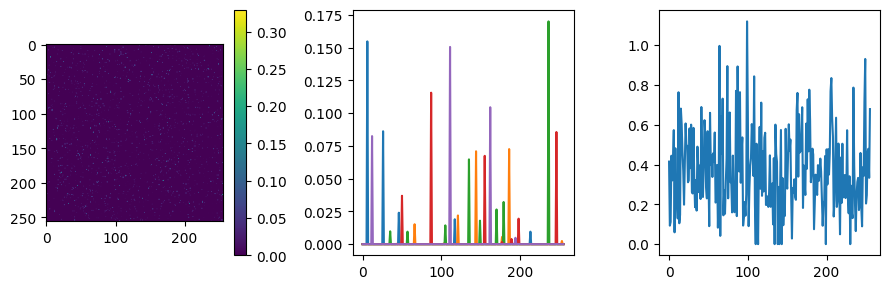

alive 248 / 256
sparsity 0.021544346900318832 mean score -0.14692421642041975 


1000 [('loss_l2', 0.0002443998912983173), ('loss_l1', 0.0012468171489590613), ('loss_negent', -0.004809801099955902)]
2000 [('loss_l2', 0.0001620197763259057), ('loss_l1', 0.0012805896662175654), ('loss_negent', -0.007132484531961382)]
3000 [('loss_l2', 0.0001489599191554589), ('loss_l1', 0.0013373116963775829), ('loss_negent', -0.00811797162378207)]
4000 [('loss_l2', 0.00014102966811333317), ('loss_l1', 0.001371071543660946), ('loss_negent', -0.008834240500815212)]
5000 [('loss_l2', 0.00013578013506776188), ('loss_l1', 0.001389407583978027), ('loss_negent', -0.009356069333851337)]
6000 [('loss_l2', 0.00013298046815907581), ('loss_l1', 0.0013977851329836995), ('loss_negent', -0.009692243937402964)]
7000 [('loss_l2', 0.00013190241470874753), ('loss_l1', 0.0014027841720962897), ('loss_negent', -0.00991200343426317)]
8000 [('loss_l2', 0.00013121002359548585), ('loss_l1', 0.0014012932492187247), ('loss_negent'

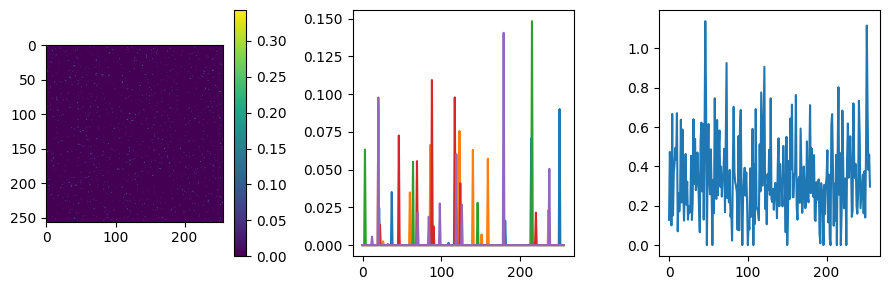

alive 246 / 256
sparsity 0.046415888336127774 mean score -0.14554611520039115 


1000 [('loss_l2', 0.00024551010171528794), ('loss_l1', 0.0012334660335269932), ('loss_negent', -0.004763709665457537)]
2000 [('loss_l2', 0.00016273896516941021), ('loss_l1', 0.0012781802776735277), ('loss_negent', -0.007104571140371263)]
3000 [('loss_l2', 0.000149748545998591), ('loss_l1', 0.0013370902553433552), ('loss_negent', -0.008108769897837192)]
4000 [('loss_l2', 0.00014124517116579228), ('loss_l1', 0.001372573669650592), ('loss_negent', -0.008858404755592346)]
5000 [('loss_l2', 0.0001355916782922577), ('loss_l1', 0.0013941892203874885), ('loss_negent', -0.009373727797530592)]
6000 [('loss_l2', 0.00013246008049463853), ('loss_l1', 0.001404101261170581), ('loss_negent', -0.009742209534160794)]
7000 [('loss_l2', 0.00013111326821672265), ('loss_l1', 0.0014065427866298706), ('loss_negent', -0.009970426802523434)]
8000 [('loss_l2', 0.0001305647734552622), ('loss_l1', 0.0014087629944551736), ('loss_negent

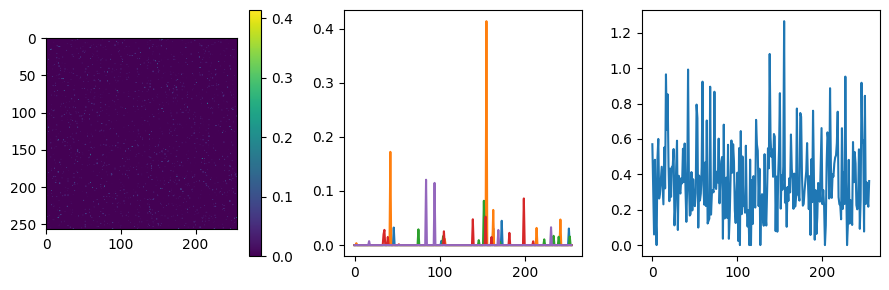

alive 250 / 256
sparsity 0.1 mean score -0.14602119822800158 


1000 [('loss_l2', 0.0002465280626716044), ('loss_l1', 0.0012505365704599354), ('loss_negent', -0.0047021320805634625)]
2000 [('loss_l2', 0.00016372942112502642), ('loss_l1', 0.0012743717005942016), ('loss_negent', -0.006994903351180255)]
3000 [('loss_l2', 0.00014929862407734616), ('loss_l1', 0.0013382901700679213), ('loss_negent', -0.008046834752894938)]
4000 [('loss_l2', 0.0001406833736837143), ('loss_l1', 0.0013739176363451405), ('loss_negent', -0.008791921641677618)]
5000 [('loss_l2', 0.00013499922970368062), ('loss_l1', 0.0013957612937083468), ('loss_negent', -0.009343875203281641)]
6000 [('loss_l2', 0.00013186716321797576), ('loss_l1', 0.0014053259778302163), ('loss_negent', -0.009702023494057358)]
7000 [('loss_l2', 0.0001307361921426491), ('loss_l1', 0.0014095460318494589), ('loss_negent', -0.009937983887270093)]
8000 [('loss_l2', 0.00013014409295283258), ('loss_l1', 0.0014115198795916512), ('loss_negent', -0.0100853

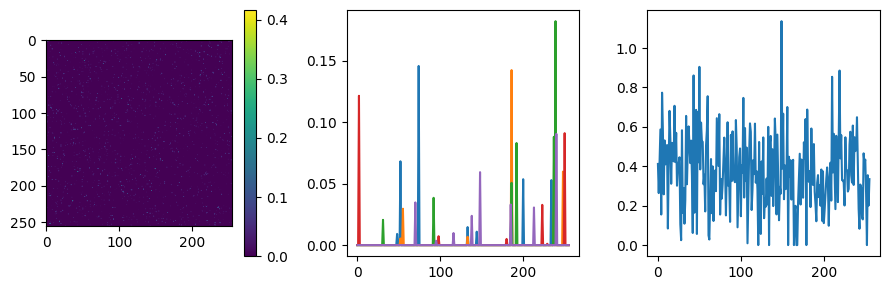

alive 248 / 256
sparsity 0.21544346900318823 mean score -0.14416162149920578 


1000 [('loss_l2', 0.00024396641764089236), ('loss_l1', 0.0012453876291662195), ('loss_negent', -0.004883592507079035)]
2000 [('loss_l2', 0.0001617029468761757), ('loss_l1', 0.0012813936658203602), ('loss_negent', -0.007136294862255454)]
3000 [('loss_l2', 0.00014773019148560707), ('loss_l1', 0.0013440565577475354), ('loss_negent', -0.008175798387266696)]
4000 [('loss_l2', 0.00014009288563102018), ('loss_l1', 0.0013764570022467525), ('loss_negent', -0.008887009126134217)]
5000 [('loss_l2', 0.000134918814903358), ('loss_l1', 0.0013950650912011042), ('loss_negent', -0.00940556050185114)]
6000 [('loss_l2', 0.00013236859971948434), ('loss_l1', 0.0014028517109109088), ('loss_negent', -0.009741402234882117)]
7000 [('loss_l2', 0.00013120030851860066), ('loss_l1', 0.0014053151709958911), ('loss_negent', -0.009957693438977002)]
8000 [('loss_l2', 0.00013084757012256888), ('loss_l1', 0.0014080571482190862), ('loss_negen

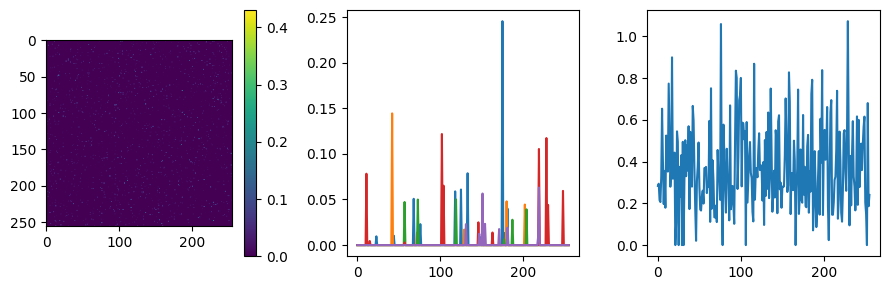

alive 248 / 256
sparsity 0.46415888336127775 mean score -0.1461481527395306 


1000 [('loss_l2', 0.00024017410101736527), ('loss_l1', 0.0012639414863432985), ('loss_negent', -0.004899244578964599)]
2000 [('loss_l2', 0.00016188780704396778), ('loss_l1', 0.0012792312528472393), ('loss_negent', -0.007139595024753362)]
3000 [('loss_l2', 0.00014944604558695572), ('loss_l1', 0.0013383952770382166), ('loss_negent', -0.008103336115833372)]
4000 [('loss_l2', 0.0001408044999552658), ('loss_l1', 0.001376243499922566), ('loss_negent', -0.008823885657824576)]
5000 [('loss_l2', 0.00013572646233660636), ('loss_l1', 0.0013919080425985157), ('loss_negent', -0.009328947512432934)]
6000 [('loss_l2', 0.00013286346568202134), ('loss_l1', 0.0013993838488822804), ('loss_negent', -0.009678282442502677)]
7000 [('loss_l2', 0.00013177146001544315), ('loss_l1', 0.0014024032378802077), ('loss_negent', -0.009909231362864375)]
8000 [('loss_l2', 0.0001313306651863968), ('loss_l1', 0.0014053170069819316), ('loss_negen

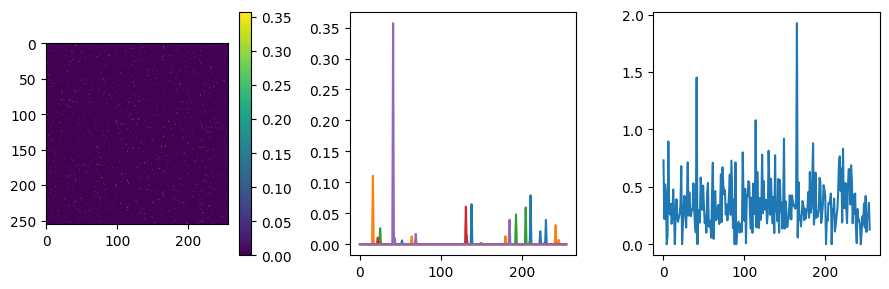

alive 247 / 256
sparsity 1.0 mean score -0.14814445579251057 




In [211]:
all_scores = []
all_Z = []
num_alive = []
for s in sparsity:
    model = SparseAutoencoder(num_in=256, num_hidden=256).to(device)
    optim = torch.optim.Adam(model.parameters(), 1e-3)
    batch_size = 256

    run_loss = {'loss_l2': [], 'loss_l1': [], 'loss_negent': []}
    for i in range(10000):
        ind = np.random.choice(X.shape[0], batch_size)
        x = torch.tensor(X[ind]).to(device)
        z, rec = model(x)
        loss_l2 = torch.mean((x - rec) ** 2)
        loss_l1 = torch.mean(torch.abs(z))
        loss_negent = -torch.mean(torch.std(z, dim=0))
        loss = loss_l2 + 1e-1 * loss_l1 + 1e-2 * loss_negent
        optim.zero_grad()
        loss.backward()
        optim.step()
        model.decoder.weight.data /= torch.linalg.norm(model.decoder.weight, dim=0)
        run_loss['loss_l2'].append(loss_l2.item())
        run_loss['loss_l1'].append(loss_l1.item())
        run_loss['loss_negent'].append(loss_negent.item())
        if i > 0 and not i % 1000:
            print(i, [(key, np.mean(run_loss[key])) for key in run_loss])
            run_loss = {'loss_l2': [], 'loss_l1': [], 'loss_negent': []}

    plt.figure(figsize=(9, 3))
    plt.subplot(1, 3, 1)
    plt.imshow(z.detach().cpu().numpy())
    plt.colorbar()
    plt.subplot(1, 3, 2)
    plt.plot(z[:5].detach().cpu().numpy().T)
    plt.subplot(1, 3, 3)
    plt.plot(z.sum(0).detach().cpu().numpy())
    plt.tight_layout()
    plt.show()
    Z = model.encode(torch.tensor(X).to(device)).detach().cpu().numpy()
    ind_alive = Z.sum(0) > 0
    print('alive', np.sum(ind_alive), '/', Z.shape[1])
    Z = Z[:, ind_alive]
    if False:
        plot_meis(Z, Z.mean(0), 
            results['inputs'], '', 
            num_show=10, show_all=False, plot=True)
    data_train, _ = get_mei_data(Z, results['inputs'])
    scores = -get_monosemanticity(data_train)
    all_scores.append(scores.copy())
    all_Z.append(Z.copy())
    num_alive.append(np.sum(ind_alive))
    print('sparsity', s, 'mean score', scores.mean(), '\n\n')



[]

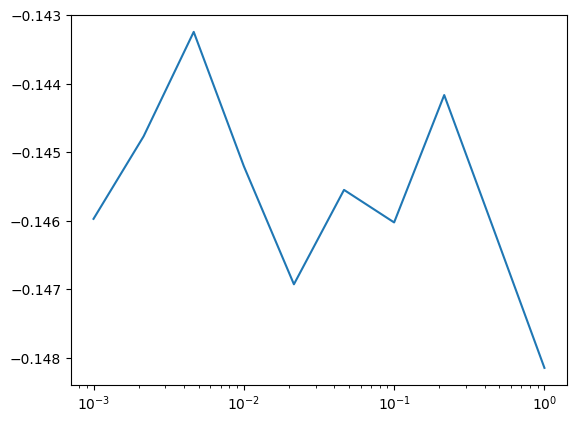

In [212]:
plt.plot(sparsity[:len(all_scores)], [_.mean() for _ in all_scores])
plt.semilogx()

[-0.15783558161638211, -0.14015665491024265, -0.14596906215845307, -0.14476387572276544, -0.14323935471856813, -0.14519928198032936, -0.14692421642041975, -0.14554611520039115, -0.14602119822800158, -0.14416162149920578, -0.1461481527395306, -0.14814445579251057]


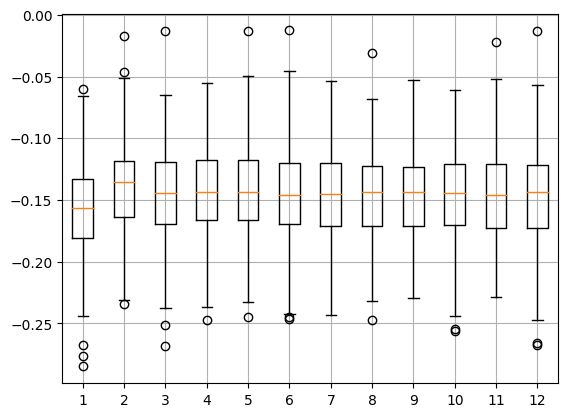

In [213]:
tmp = [
    -results['layer1']['monosemanticity'],
    -results['layer1']['monosemanticity_kmeans_256'],
] + all_scores
print([np.mean(t) for t in tmp])
plt.boxplot(tmp)
plt.grid()